## 房价预测案例

kaggle地址：https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 步骤一：检视数据集

In [1]:
import numpy as np
import pandas as pd

In [2]:
# 进行数据的读取  kaggle中默认把数据放在 input文件夹下面
train_df = pd.read_csv('./input/train.csv',index_col=0)
test_df = pd.read_csv('./input/test.csv', index_col=0)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 从上图我们可以看到原始数据大概有80个特征

## 数据合并
这么做主要是为了使用DataFrame进行数据预处理的方便，等所有的需要的预处理结束之后，我们再把它进行分开

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113428048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11352c358>]], dtype=object)

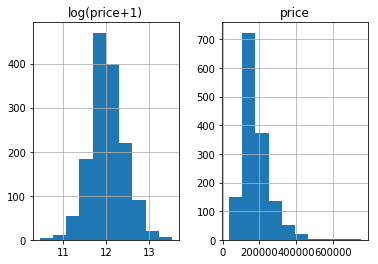

In [6]:
%matplotlib inline
prices = pd.DataFrame({'price':train_df['SalePrice'], 'log(price+1)':np.log1p(train_df['SalePrice'])})
prices.hist()

In [7]:
# 从上面的图中，我们发现label本身并不平滑，为了我们分类器的学习更加准确，我们会首先把label进行“平滑化”处理（正态化），
# 这里我们使用的是 log1p 也就是 log(x+1)，避免负值问题
# 我们在把数据进行平滑处理之后没那么最后计算结果的时候，要记得把预测到的平滑数据给变回去。

In [8]:
y_train = np.log1p(train_df.pop('SalePrice'))

In [9]:
# 这里我们对数据进行合并操作
all_df = pd.concat((train_df, test_df), axis=0)

In [10]:
all_df.shape

(2919, 79)

In [11]:
# y_train 就是 SalePrice那一列
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## 变量转化
目的就是把 不方便或者不统一的数据给统一了

### 正确化变量属性

In [12]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [14]:
# 我们注意到 MSSubClass 的值其实应该是一个类目 category
# 但是Pandas并不明白这件事情，使用DF的时候，这类数字符号会被默认记成数字
# 这类东西有误导性，我们需要把他们变成 string
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

In [15]:
# 对这一列属性进行一个数量统计
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

把category的变量类型转化成 numerical表达形式
当我们用numerical来表达categoical的时候，要注意，数字本身有大小的含义，所以最好不要使用单纯的数字表示，常用的我们可以使用 one-hot 的方法来表示 category

pandas 自带 get_dummies方法，可以帮助我们一键 one-hot

In [16]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [17]:
# 同理我们把所有的 category都给 one-hot
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [18]:
all_dummy_df.shape

(2919, 303)

In [19]:
# 下面我们来处理缺失值问题
# 我们先来统计一下 缺失值 比较多的列
all_dummy_df.isnull().sum().sort_values(ascending = False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [20]:
# 如何处理这些缺失值，这就需要我们仔细审题，一般来说，数据集的描述里会写清楚这些缺失都代表着什么，
# 如果实在没有，只能靠我们自己解决，用合理的方式来填充 
# 在这里我们是以平均值进行填充

In [21]:
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [22]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [23]:
# 再检查一遍是否还有缺失值
all_dummy_df.isnull().sum().sum()

0

###  标准化numerical数据
这一步并不是必要的，需要看你使用的是什么分类器，regression的分类器都比较傲娇，最好把原数据集放在一个标准分布内，不要让数据间的差距太大。
这里，我们的目标是那些本来就是numerical的数据。

In [24]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [25]:
# 使数据平滑的办法有很多种，这里我们采用另外一种办法：计算标准分布
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## 建立模型
把数据分回 训练集/测试集

In [33]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [34]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

### 使用Ridge Regression
用 Ridge Regression 模型来跑一遍。（对于多因子的数据集，这种模型可以方便的把所有的var都无脑的放进去）

In [31]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [36]:
# 这一步将 DF 数据集 转换成 numpy的 array 
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [37]:
# 用 sklearn中的 cross validation 方法来测试模型
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

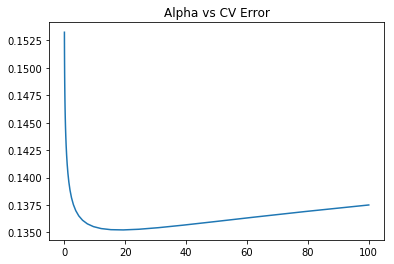

In [38]:
# 存下 alpha值 然后看看哪一个 alpha更好一些
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

上图可见，大概 aplha = 10-20的时候，可以 score 达到 0.135左右

## 随机森林

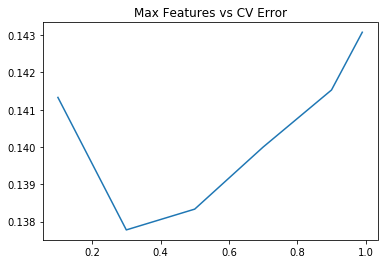

In [39]:
from sklearn.ensemble import RandomForestRegressor

max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

使用随机森林最优值 达到了 0.137

## Ensemble
这里我们使用一个Stacking的思想来汲取两种或者多种模型的优点
首先，我们把最好的 parameter拿出来，做成我们最终的model

In [40]:
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500, max_features=.3)

In [41]:
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

上面提到了，因为最前面我们给label做了个log(1+x), 于是这里我们需要把predit的值给exp回去，并且减掉那个"1"

所以就是我们的expm1()函数。

In [42]:
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

一个正经的Ensemble是把这群model的预测结果作为新的input，再做一次预测。这里我们简单的方法，就是直接『平均化』。

In [43]:
y_final = (y_ridge + y_rf) / 2

## 提交结果

In [44]:
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})
submission_df.head(10)

,Id,SalePrice
0,1461,119578.442069
1,1462,151551.305052
2,1463,173880.456645
3,1464,189096.962912
4,1465,196111.215041
5,1466,175740.617805
6,1467,177186.541997
7,1468,169247.060788
8,1469,184093.934811
9,1470,124030.996570
